In [ ]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Load the datasets
local_file_path = 'data/times_local.csv'
cluster_file_path = 'data/times_cluster.csv'

df_local = pd.read_csv(local_file_path)
df_cluster = pd.read_csv(cluster_file_path)

# Display the first few rows of each DataFrame
df_local.head(), df_cluster.head()


In [4]:
#  Remove spaces from column names
df_local.columns = df_local.columns.str.strip()
df_cluster.columns = df_cluster.columns.str.strip()

# Add a 'Machine' column to identify the source
df_local['Machine'] = 'Local'
df_cluster['Machine'] = 'Cluster'

df_combined = pd.concat([df_local, df_cluster], ignore_index=True)

# Convert Execution_Time to numeric in case of any format issues
df_combined['Execution_Time'] = pd.to_numeric(df_combined['Execution_Time'], errors='coerce')

df_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Program         20 non-null     object 
 1   Key             20 non-null     int64  
 2   Plaintext       20 non-null     object 
 3   Search_Phrase   20 non-null     object 
 4   Key_Found       20 non-null     int64  
 5   Decrypted_Text  20 non-null     object 
 6   Execution_Time  20 non-null     float64
 7   Machine         20 non-null     object 
dtypes: float64(1), int64(2), object(5)
memory usage: 1.4+ KB


In [5]:
# Summary statistics
df_combined.describe()

# Checking for missing values
df_combined.isnull().sum()

Program           0
Key               0
Plaintext         0
Search_Phrase     0
Key_Found         0
Decrypted_Text    0
Execution_Time    0
Machine           0
dtype: int64

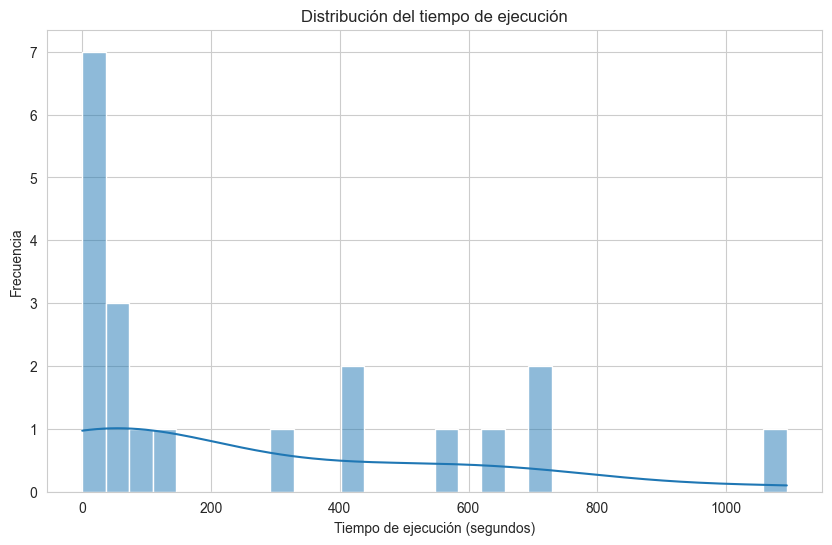

In [6]:
# Distribution of execution times
plt.figure(figsize=(10, 6))
sns.histplot(df_combined['Execution_Time'], bins=30, kde=True)
plt.title('Distribución del tiempo de ejecución')
plt.xlabel('Tiempo de ejecución (segundos)')
plt.ylabel('Frecuencia')
plt.show()


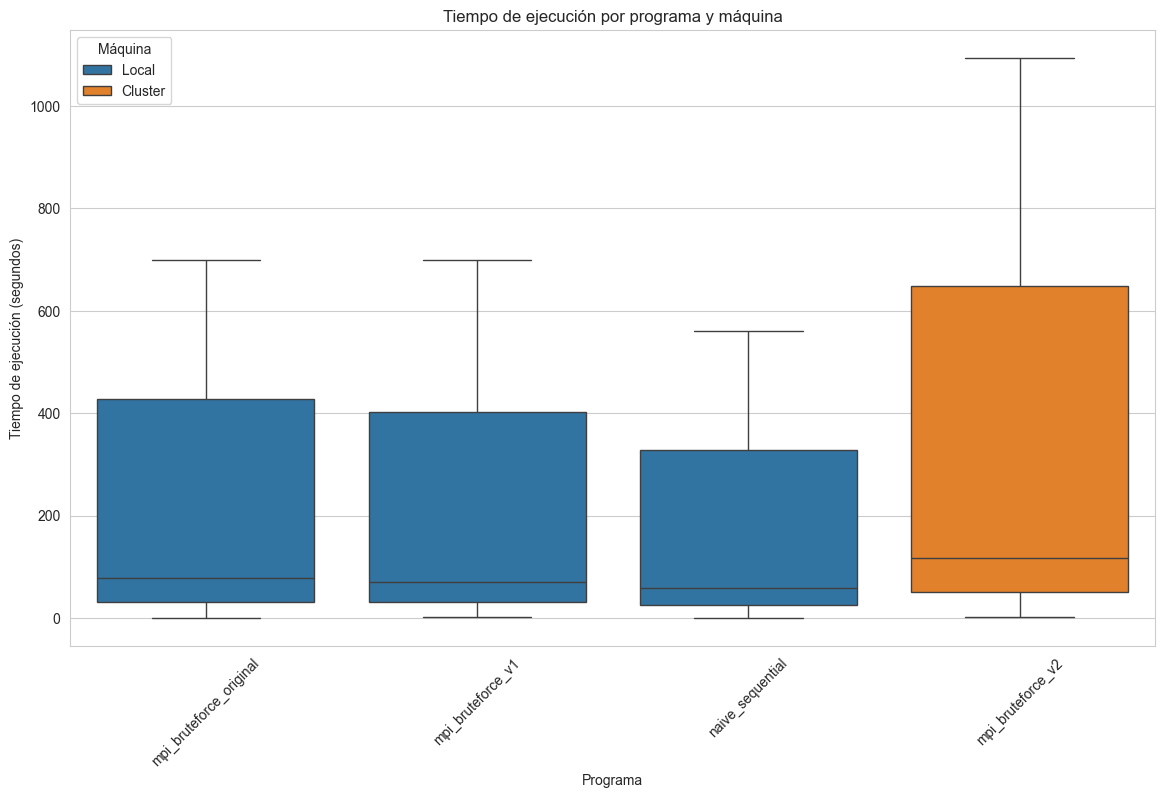

In [7]:
# Boxplot of execution times by program
plt.figure(figsize=(14, 8))
sns.boxplot(x='Program', y='Execution_Time', hue='Machine', data=df_combined)
plt.title('Tiempo de ejecución por programa y máquina')
plt.xlabel('Programa')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.xticks(rotation=45)
plt.legend(title='Máquina')
plt.show()


In [8]:
# Group by Program and Machine to get mean and median execution times
execution_stats = df_combined.groupby(['Program', 'Machine'])['Execution_Time'].agg(['mean', 'median']).reset_index()

execution_stats.columns = ['Programa', 'Máquina', 'Tiempo_medio', 'Mediana'] 
execution_stats


,Programa,Máquina,Tiempo_medio,Mediana
0,mpi_bruteforce_original,Local,247.405604,77.2557
1,mpi_bruteforce_v1,Local,240.327144,70.3974
2,mpi_bruteforce_v2,Cluster,382.456640,116.5180
3,naive_sequential,Local,194.033469,57.6434


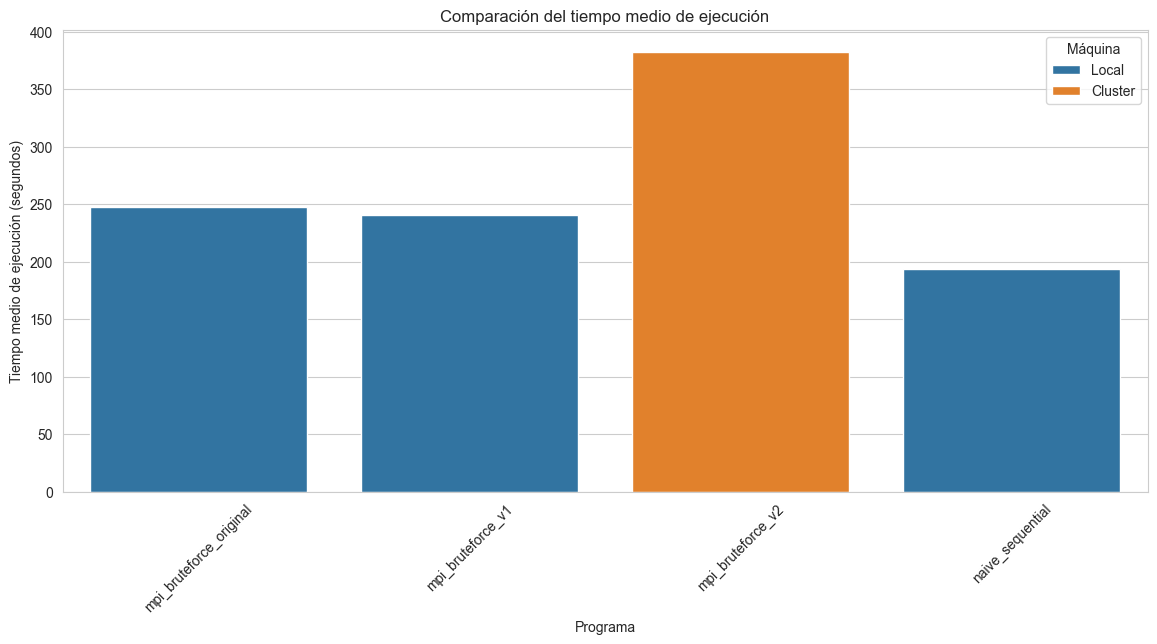

In [9]:
# Barplot of mean execution times by program and machine
plt.figure(figsize=(14, 6))
sns.barplot(x='Programa', y='Tiempo_medio', hue='Máquina', data=execution_stats)
plt.title('Comparación del tiempo medio de ejecución')
plt.xlabel('Programa')
plt.ylabel('Tiempo medio de ejecución (segundos)')
plt.legend(title='Máquina')
plt.xticks(rotation=45)
plt.show()


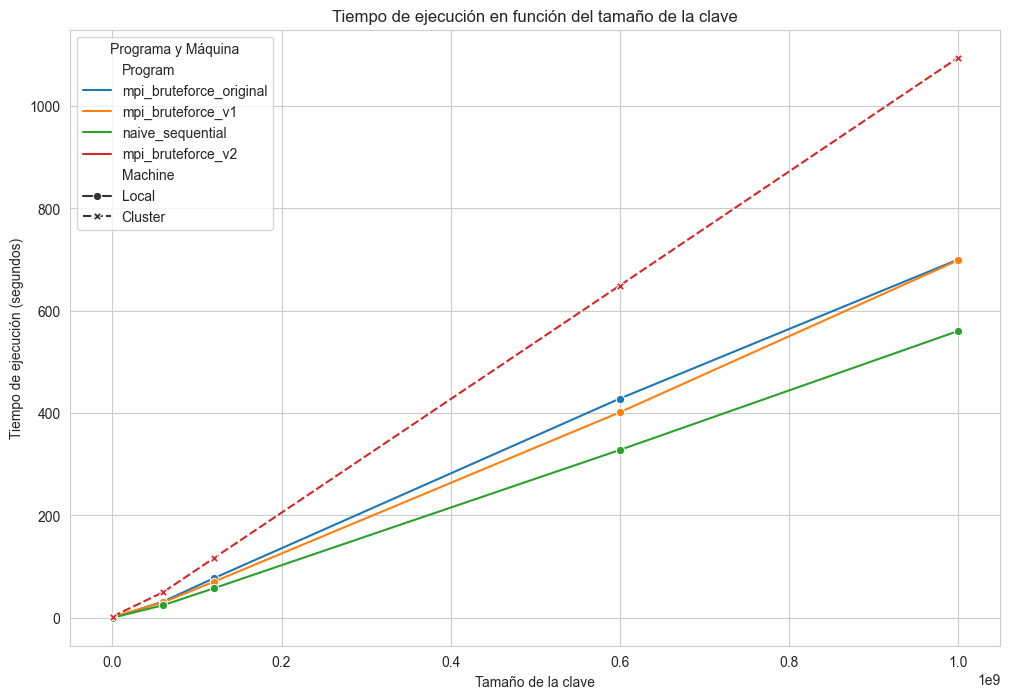

In [10]:
# Plot Execution Time vs. Key Size for different programs and machines
plt.figure(figsize=(12, 8))
sns.lineplot(x='Key', y='Execution_Time', hue='Program', style='Machine', data=df_combined, markers=True)
plt.title('Tiempo de ejecución en función del tamaño de la clave')
plt.xlabel('Tamaño de la clave')
plt.ylabel('Tiempo de ejecución (segundos)')
plt.legend(title='Programa y Máquina')
plt.show()

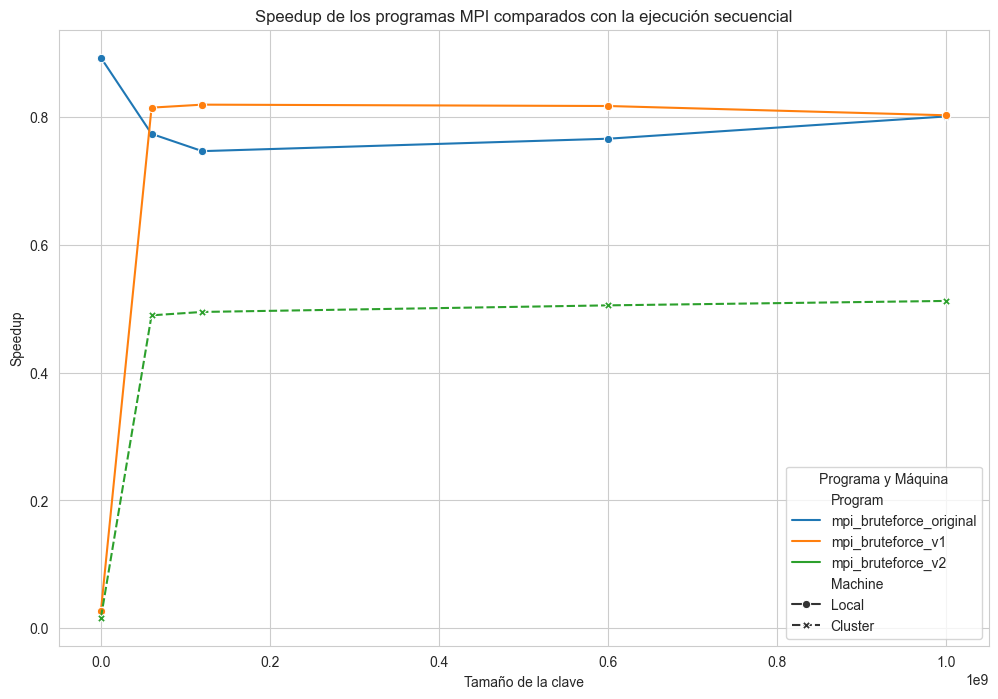

,Programa,Máquina,Speedup_medio_sequential,Mediana_sequential
0,mpi_bruteforce_original,Local,0.795496,0.773156
1,mpi_bruteforce_v1,Local,0.655813,0.814155
2,mpi_bruteforce_v2,Cluster,0.403544,0.494717


In [20]:
# Calculate speedup relative to naive_sequential
sequential_times = df_combined[(df_combined['Program'] == 'naive_sequential') & (df_combined['Machine'] == 'Local')].set_index('Key')['Execution_Time']
df_combined['Speedup_sequential'] = df_combined.apply(
    lambda row: sequential_times[row['Key']] / row['Execution_Time'] if row['Key'] in sequential_times.index else None, axis=1
)

# Plot Speedup for MPI programs compared to naive_sequential
plt.figure(figsize=(12, 8))
sns.lineplot(x='Key', y='Speedup_sequential', hue='Program', style='Machine', data=df_combined[df_combined['Program'].str.contains('mpi')], markers=True)
plt.title('Speedup de los programas MPI comparados con la ejecución secuencial')
plt.xlabel('Tamaño de la clave')
plt.ylabel('Speedup')
plt.legend(title='Programa y Máquina')
plt.show()

# Table summarizing Speedup relative to naive_sequential
speedup_stats_sequential = df_combined[df_combined['Program'].str.contains('mpi')].groupby(['Program', 'Machine'])['Speedup_sequential'].agg(['mean', 'median']).reset_index()
speedup_stats_sequential.columns = ['Programa', 'Máquina', 'Speedup_medio_sequential', 'Mediana_sequential']
speedup_stats_sequential


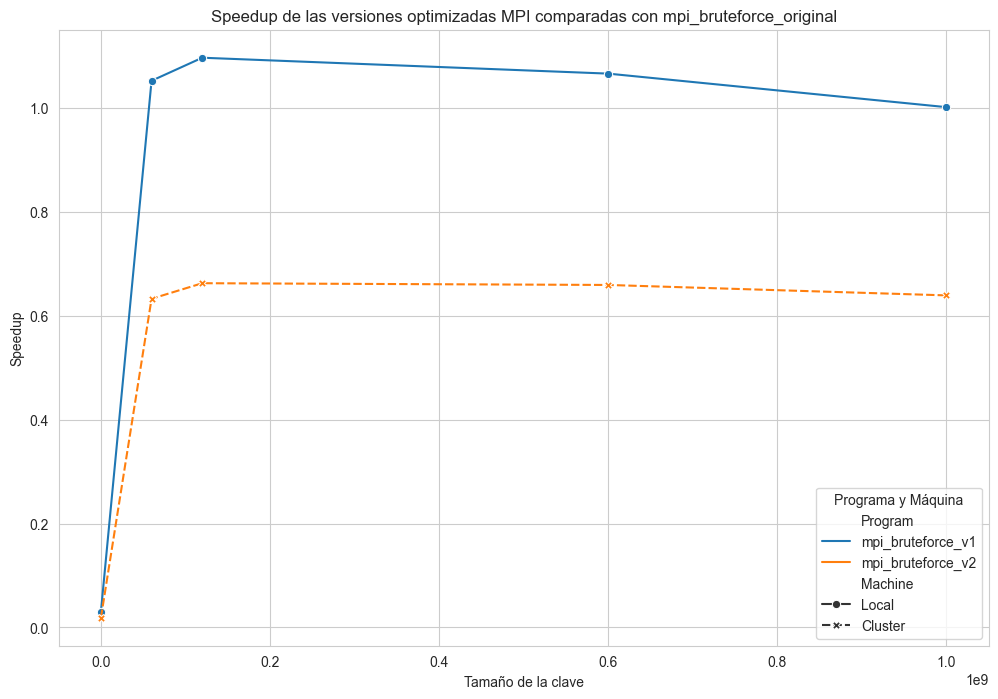

,Programa,Máquina,Speedup_medio_original,Mediana_original
0,mpi_bruteforce_v1,Local,0.849987,1.053027
1,mpi_bruteforce_v2,Cluster,0.522789,0.639583


In [26]:
# Plot Speedup for optimized MPI programs compared to mpi_bruteforce_original
plt.figure(figsize=(12, 8))
sns.lineplot(x='Key', y='Speedup_original_mpi', hue='Program', style='Machine', data=df_combined[df_combined['Program'].isin(['mpi_bruteforce_v1', 'mpi_bruteforce_v2'])], markers=True)
plt.title('Speedup de las versiones optimizadas MPI comparadas con mpi_bruteforce_original')
plt.xlabel('Tamaño de la clave')
plt.ylabel('Speedup')
plt.legend(title='Programa y Máquina')
plt.show()

# Table summarizing Speedup relative to mpi_bruteforce_original
speedup_stats_original = df_combined[df_combined['Program'].isin(['mpi_bruteforce_v1', 'mpi_bruteforce_v2'])].groupby(['Program', 'Machine'])['Speedup_original_mpi'].agg(['mean', 'median']).reset_index()
speedup_stats_original.columns = ['Programa', 'Máquina', 'Speedup_medio_original', 'Mediana_original']
speedup_stats_original


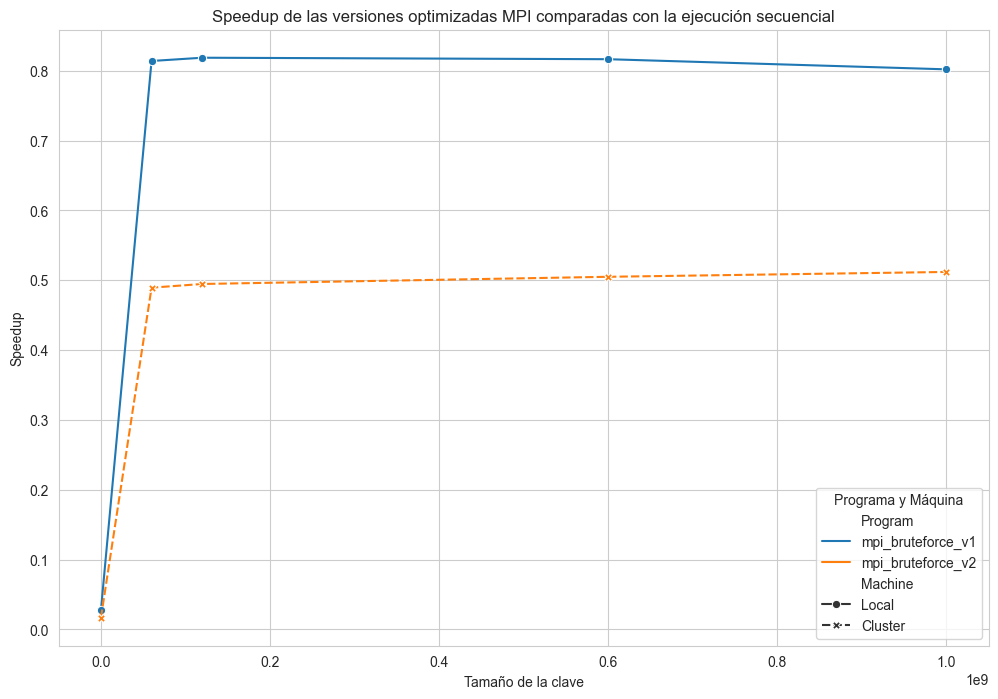

,Programa,Máquina,Speedup_medio_sequential,Mediana_sequential
0,mpi_bruteforce_v1,Local,0.655813,0.814155
1,mpi_bruteforce_v2,Cluster,0.403544,0.494717


In [27]:
# Plot Speedup for optimized MPI programs compared to naive_sequential
plt.figure(figsize=(12, 8))
sns.lineplot(x='Key', y='Speedup_sequential', hue='Program', style='Machine', data=df_combined[df_combined['Program'].isin(['mpi_bruteforce_v1', 'mpi_bruteforce_v2'])], markers=True)
plt.title('Speedup de las versiones optimizadas MPI comparadas con la ejecución secuencial')
plt.xlabel('Tamaño de la clave')
plt.ylabel('Speedup')
plt.legend(title='Programa y Máquina')
plt.show()

# Table summarizing Speedup relative to naive_sequential for optimized versions
speedup_stats_optimized_sequential = df_combined[df_combined['Program'].isin(['mpi_bruteforce_v1', 'mpi_bruteforce_v2'])].groupby(['Program', 'Machine'])['Speedup_sequential'].agg(['mean', 'median']).reset_index()
speedup_stats_optimized_sequential.columns = ['Programa', 'Máquina', 'Speedup_medio_sequential', 'Mediana_sequential']
speedup_stats_optimized_sequential
